# Verify Environment Setup in qBraid Lab

In [1]:
#!rm ~/.qbraid/qbraidrc

In [3]:
#!ls ~/.qbraid

environments  qBraidCredits  quantum-jobs


In [2]:
#!cat ~/.qbraid/qbraidrc

#### 1. Use the [qBraid CLI](https://qbraid-qbraid.readthedocs-hosted.com/en/latest/cli/qbraid.html) to verify that the HAQS-2022 environment is installed and active.

In [1]:
# verify that `haqs` is listed under installed environments.
!qbraid envs list

Installed environments:
qsharp
default
haqs
amazon_braket
pennylane
Use `qbraid envs -h` to see available commands.


In [2]:
# verify that `python3_haqs_dk5kt8` is listed under available kernels.
!qbraid kernels list

Available kernels:
  iqsharp                      /home/jovyan/.local/share/jupyter/kernels/iqsharp
  python3_aws_braket_kwx6dl    /home/jovyan/.local/share/jupyter/kernels/python3_aws_braket_kwx6dl
  python3_haqs_dk5kt8          /home/jovyan/.local/share/jupyter/kernels/python3_haqs_dk5kt8
  python3_xanadu_fil4xi        /home/jovyan/.local/share/jupyter/kernels/python3_xanadu_fil4xi
  python3                      /opt/conda/share/jupyter/kernels/python3


#### 2. [Switch notebook kernel](https://qbraid-qbraid.readthedocs-hosted.com/en/latest/lab/kernels.html#switch-notebook-kernel) to `Python 3 [HAQS-2022]` and verify that qBraid quantum jobs are working.

In [3]:
# enable qBraid quantum jobs in `haqs` environment
!qbraid jobs enable haqs

You have already enabled qBraid Quantum Jobs in the haqs environment.


In [5]:
#from braket.circuits import Circuit
# create the Amazon Braket circuit
#bell = Circuit().h(0).cnot(0, 1)
#print(bell)

In [4]:
import json
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler

In [6]:
# choose the cloud-based on-demand simulator to run your circuit
#device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/dm1")
device = AwsDevice('arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6') #D-Wave 2000Q
#device = AwsDevice('arn:aws:braket:::device/qpu/d-wave/Advantage_system4') #D-Wave Advantage_system4.1

In [5]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

In [7]:
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import networkx as nx
import dwave_networkx as dnx
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite

Setting the Max-Cut problem

In [8]:
# helper function to plot graph
def get_graph(graph, pos):
    """
    plot colored graph for given solution
    """
    # positions for all nodes
    # pos = nx.spring_layout(graph)

    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(graph, pos)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=20, font_family='sans-serif')

    # plot the graph
    plt.axis('off')
    #plt.savefig("figures/random_graph.png") # save as png
    plt.show();

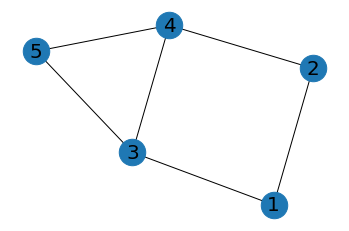

In [9]:
# Copyright 2019 D-Wave Systems, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# ------ Import necessary packages ----
from collections import defaultdict

# from dwave.system.samplers import DWaveSampler
# from dwave.system.composites import EmbeddingComposite

# ------- Set up the graph -------

# Create empty graph
G = nx.Graph()

# Add edges to the graph (also adds nodes)
G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)])

# plot graph
pos = nx.spring_layout(G)
# plot graph with labels
get_graph(G, pos)

# ------- Set up the QUBO dictionary -------

# Initialize our Q matrix
Q = defaultdict(int)

# Update Q matrix for every edge in the graph
for u, v in G.edges:
    Q[(u,u)]+= -1
    Q[(v,v)]+= -1
    Q[(u,v)]+= 2

# print Q matrix
# print('Show Q matrix:', Q)

Solving the Max-Cut problem on D-Wave

In [12]:
# ------- Run the QUBO problem on the QPU -------
# Set up QPU parameters
chainstrength = 8
numruns = 10

# Run the QUBO on the Braket solver from your config file
# set sampler
sampler = BraketDWaveSampler(device_arn='arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
sampler = EmbeddingComposite(sampler)
response = sampler.sample_qubo(Q, chain_strength=chainstrength, num_reads=numruns)
energies = iter(response.data())

# ------- Print results to user -------
print('-' * 60)
print('{:>15s}{:>15s}{:^15s}{:^15s}'.format('Set 0','Set 1','Energy','Cut Size'))
print('-' * 60)
for line in response:
    S0 = [k for k,v in line.items() if v == 0]
    S1 = [k for k,v in line.items() if v == 1]
    E = next(energies).energy
    print('{:>15s}{:>15s}{:^15s}{:^15s}'.format(str(S0),str(S1),str(E),str(int(-1*E))))

# ------- Display results to user -------
# Grab best result
# Note: "best" result is the result with the lowest energy
# Note2: the look up table (lut) is a dictionary, where the key is the node index
#   and the value is the set label. For example, lut[5] = 1, indicates that
#   node 5 is in set 1 (S1).
lut = response.lowest().first.sample

# Interpret best result in terms of nodes and edges
S0 = [node for node in G.nodes if not lut[node]]
S1 = [node for node in G.nodes if lut[node]]
cut_edges = [(u, v) for u, v in G.edges if lut[u]!=lut[v]]
uncut_edges = [(u, v) for u, v in G.edges if lut[u]==lut[v]]

# Display best result
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color='c')
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
nx.draw_networkx_labels(G, pos)

filename = "maxcut_plot.png"
plt.savefig(filename, bbox_inches='tight')
print("\nYour plot is saved to {}".format(filename))

ClientError: An error occurred (UnrecognizedClientException) when calling the GetDevice operation: The security token included in the request is invalid.

In [ ]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost()} USD")

In [9]:
# list submitted jobs
!qbraid jobs list

Sun Oct 30 2022 09:40:31 GMT+0000 (Coordinated Universal Time) arn:aws:braket:::device/quantum-simulator/amazon/dm1 arn:aws:braket:us-east-1:592242689881:quantum-task/0621c49d-0994-4186-a962-cc5418b9c75d



In [11]:
# check remaining qBraid credits
!qbraid jobs get-credits

You have 1499.59999988 remaining qBraid credits.


#### 3. Congrats! If all of these tests passed then you are ready to begin working on the HAQS challenges.